In [1]:
import sys
sys.path.insert(0, '/home/tomma/litebird/litebird_sim_clone/litebird_sim')
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
nside = 64
mission_time_is_sec = 3600
instrument = "MFT"
channel = "M1-100"
sampling = 1 # this replaces channelinfo.sampling_rate_hz

In [3]:
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [4]:
mft_file = sim.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(name=instrument, 
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
    )
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/channel_info",
    imo=imo,
    )
hwp_radpsec = mft_file.metadata["hwp_rpm"]*2.0*np.pi/60.0

In [5]:
dets=[]
detquats=[]
#for detname in channelinfo.detector_names[0:20]:
for detname in ('M03_030_QA_100T','M03_030_QA_100B'): #we choose the couple of detector at the MFT boresight
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/"+detname+"/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

## Create file with HWP non-ideal parameters for MFT
#### The files 'M/HFT_Mesh_HWP_v2.txt' are given from the simulated HWP profiles at https://wiki.kek.jp/download/attachments/123338913/2019_06_22_MFT_HFT_HWP_GP_to_LB_team.xlsx?version=1&modificationDate=1585750021431&api=v2. We read the MFT one to convert the parameters in the way defined in Giardiello et al.

In [6]:
mft = np.loadtxt('MFT_Mesh_HWP_v2.txt')     

nu = mft[:,0]
h1 = np.sqrt(mft[:,1]) - 1.
h2 = np.sqrt(mft[:,3]) - 1.
beta  = mft[:,5] - 180.
z1 = 0.01*np.ones_like(nu) 
z2 = 0.01*np.ones_like(nu)

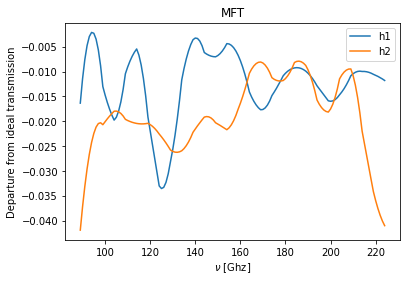

In [7]:
plt.plot(nu,h1,label='h1')
plt.plot(nu,h2,label='h2')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal transmission')
plt.title('MFT')
plt.legend()

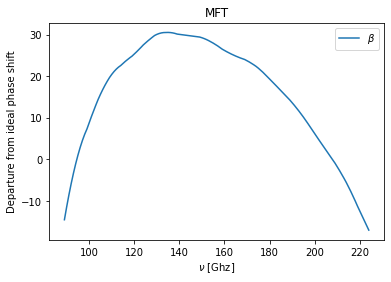

In [8]:
plt.plot(nu,beta,label=r'$\beta$')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal phase shift')
plt.title('MFT')
plt.legend()

for the purpose of this exercise, let's focus on the frequencies of the 100 GHz band (89,111)

In [9]:
i_i = np.where(nu == 89)[0][0]
i_f = np.where(nu == 191)[0][0]
Nu=nu[i_i:i_f]
H1=h1[i_i:i_f]
H2=h2[i_i:i_f]
Beta=beta[i_i:i_f]
Z1=z1[i_i:i_f]
Z2=z2[i_i:i_f]

In [10]:
np.savetxt('MFT_140_h_beta_z.txt', np.column_stack((Nu,H1,H2,Beta,Z1,Z2))) 

Our code assumes we also have an header, let's write it:

In [11]:
header = '# nu   h1   h2   beta   z1   z2'
file = open('MFT_140_h_beta_z.txt', 'r')
lines = [line for line in file]
file.close()
file = open('MFT_140_h_beta_z.txt', 'w')
# Rewrite the file: append header if needed, and all lines which previously were there
# excluding any misplaced header lines which were not at row 1
file.write(header + '\n')
file.write(''.join([line for line in lines]))
file.close()

In [12]:
par = {'hwp_sys':
       {'band_filename': 'MFT_140_h_beta_z.txt',
        'band_filename_solver': 'MFT_140_h_beta_z.txt',  #same as tod parameters
        'bandpass':{
            'band_type': 'top_hat_with_exp_wings',
            'band_low_edge': 119,
            'band_high_edge': 161,
            'band_alpha': 1., 
            'band_beta': 0.5},
        'bandpass_solver':{
            'band_type': 'chebyshev',
            'band_low_edge': 119,
            'band_high_edge': 161,
            'band_alpha': 3., 
            'band_beta': 3},
        'include_beam_throughput': False
        },
      }

## Fill tod with a band top-hat + wings

In [13]:
obs_w, = sim.create_observations(detectors=dets)

pointings = lbs.get_pointings(obs_w,
                              spin2ecliptic_quats=sim.spin2ecliptic_quats,
                              detector_quats=detquats,
                              bore2spin_quat=instrumentinfo.bore2spin_quat,
                              )

if you are using band integration (`integrate_in_band = True` in `hwp_sys.set_parameters`) you don't need to create a map beforehand, the `set_parameters` function of HwpSys will generate one cmb+fg map for each frequency. The following cell is commented because it is not needed when using band integration

In [14]:
#Mbsparams = lbs.MbsParameters(make_cmb =True,
#                              make_fg = False,
#                              gaussian_smooth = True,
#                              bandpass_int = False,
#                              nside = nside,
#                             )

#mbs = lbs.Mbs(simulation=sim,
#              parameters=Mbsparams,
#              channel_list=channelinfo,
#             )
#maps = mbs.run_all()[0][channel]

In [15]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [16]:
Mbsparams = lbs.MbsParameters(
                make_cmb=True,
                make_fg=True,
                fg_models = ["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
                bandpass_int=True,
                maps_in_ecliptic=True,
                seed_cmb = 1234,
                nside = nside
            )

the next command will take a while with band integration, since it has to generate one map per frequency

In [17]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       Mbsparams = Mbsparams,
                       Channel = channelinfo
                       )

[2022-03-18 16:49:35,295 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-18 16:49:35,296 INFO MPI#0000] generating and saving cmb simulations
/home/tomma/.local/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220318.fits
  warnings.warn(f"Access data from {full_path}")


***************** D
***************** D
***************** D


[2022-03-18 16:49:36,526 INFO MPI#0000] generating and saving fg simulations
/home/tomma/.local/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/tomma/.local/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/tomma/.local/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/tomma/.local/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ff_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/tomma/.local/lib/python3.8/s

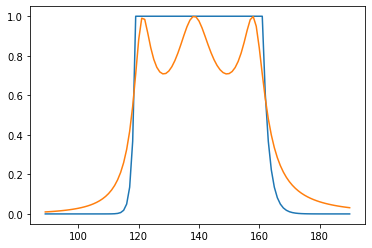

In [18]:
plt.plot(hwp_sys_band.freqs, hwp_sys_band.bandpass_profile)
plt.plot(hwp_sys_band.freqs, hwp_sys_band.bandpass_profile_solver)

In [19]:
hwp_sys_band.fill_tod(obs_w,pointings,hwp_radpsec)

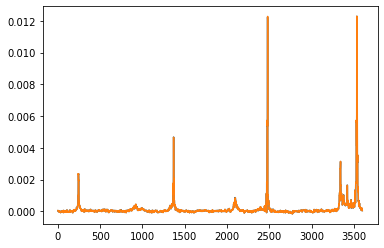

In [20]:
plt.plot(obs_w.tod[0])
plt.plot(obs_w.tod[1])